<a href="https://colab.research.google.com/github/potgie/tmp-pub/blob/main/Complexity_Lab_Project_Finance_02_Portfolio_Dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Correlation Subnetwork + Markowitz + Graph Dynamics

# =======================
# Parameters
# =======================
UNIVERSE = "DOW30"           # @param ["SP500","NASDAQ100","DOW30","CUSTOM_EQUITY_ONLY"]
TOP_N_EQUITIES = 40          # @param {type:"integer"}
MAX_PER_SECTOR = 0           # @param {type:"integer"}  # 0 = skip sector caps (faster)
START_DATE = "2023-01-01"    # @param {type:"date"}
END_DATE   = "2025-09-01"    # @param {type:"date"}

# Correlation selection
TOP_K = 20                   # printed top-K for full window
USE_ABSOLUTE = True          # rank correlations by |rho|

# Subnetwork + Markowitz
SUBNETWORK_K = 20            # edges per month in subnetwork
SUBNETWORK_USE_ABS = USE_ABSOLUTE
ALLOW_SHORTING = False       # long-only min-variance if False
MIN_NODES_IN_SUBNETWORK = 3
TRADING_DAYS = 252
TOP_ASSETS_IN_STACKPLOT = 8

# Graph sparsification (visualization)
GRAPH_METHOD = "mst"         # "topk" | "mst" | "threshold"
GRAPH_TOPK   = SUBNETWORK_K
GRAPH_TAU    = 0.65          # threshold if GRAPH_METHOD == "threshold"
GRAPH_LAYOUT = "spring"      # "spring" | "kamada_kawai" | "spectral"

# Nice, colorblind-friendly group colors
# (muted aesthetic from Tableau/Okabe-Ito–ish palette)
GROUP_COLORS = {
    "EQ":     "#1f77b4",  # blue
    "ETF":    "#2ca02c",  # green
    "FX":     "#ff7f0e",  # orange
    "CRYPTO": "#9467bd",  # purple
    "CMDTY":  "#8c564b",  # brown
    "CUSTOM": "#17becf",  # cyan
    "OTHER":  "#7f7f7f",  # gray
}

# Transition cost model (per $ traded)
ONE_WAY_COST_BPS = 5.0       # set 0 for turnover only

# Visuals
LABEL_FONTSIZE = 14
VALUE_FONTSIZE = 12
TITLE_FONTSIZE = 18
EDGE_ALPHA   = 0.8
NODE_ALPHA   = 0.96
EDGE_MIN_W   = 0.8
EDGE_MAX_W   = 6.5
NODE_MIN     = 230
NODE_MAX     = 3400

# Animation — slower playback
MAKE_GRAPH_DYNAMICS = True
FPS = 10                     # fewer frames per second → longer runtime → slower video
FRAME_INTERVAL_MS = 250      # UI playback in notebook (not used by MP4 writer)
VIDEO_DPI = 200
SAVE_GIF = True

# Include groups
INCLUDE_EQUITIES = True
INCLUDE_FX       = True
INCLUDE_CRYPTO   = False
INCLUDE_COMMODS  = True
INCLUDE_ETF      = True
INCLUDE_CUSTOM   = True

# Tickers (Yahoo or Bloomberg-style)
FX_TICKERS      = "EURUSD=X, GBPUSD=X, USDJPY=X, DX=F"
CRYPTO_TICKERS  = "BTC-USD, ETH-USD"
COMMOD_TICKERS  = "GC=F, CL=F"
ETF_TICKERS     = "SPY, QQQ, TLT"
CUSTOM_TICKERS  = "TSLA, NVDA, AAPL, MSFT, META"
EQUITY_CUSTOM_TICKERS = "AAPL, MSFT, NVDA, AMZN, GOOGL, META, AVGO, LLY, TSLA, JPM"

# =======================
# Setup (keep Colab pandas 2.2.2)
# =======================
!pip -q install yfinance==0.2.43 lxml pillow networkx ffmpeg-python

import pandas as pd, numpy as np, yfinance as yf, re, os, warnings, requests, math
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter
import matplotlib as mpl
import networkx as nx
warnings.filterwarnings("ignore")
os.makedirs("/content", exist_ok=True)

# Slightly nicer global style
mpl.rcParams.update({
    "axes.facecolor": "#fafafa",
    "figure.facecolor": "white",
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "--",
})

# =======================
# Helpers
# =======================
def _fetch_wiki_tables(url: str):
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/120 Safari/537.36"}
    r = requests.get(url, headers=headers, timeout=20); r.raise_for_status()
    return pd.read_html(r.text)

def _first_table_with_ticker(tables):
    for t in tables:
        cols = [str(c).strip().lower() for c in t.columns]
        if any(x in cols for x in ["symbol","ticker"]):
            return t
    return None

def wiki_equity_universe(universe: str) -> pd.DataFrame:
    uni = universe.upper()
    if uni == "SP500":
        t = _fetch_wiki_tables("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
        t.columns = [str(c) for c in t.columns]
        df = t.rename(columns={"Symbol":"ticker","symbol":"ticker"})
    elif uni == "NASDAQ100":
        tables = _fetch_wiki_tables("https://en.wikipedia.org/wiki/NASDAQ-100")
        tdf = _first_table_with_ticker(tables)
        if tdf is None: raise RuntimeError("No Nasdaq-100 ticker table found.")
        tdf.columns = [str(c) for c in tdf.columns]
        df = tdf.rename(columns={c:"ticker" for c in tdf.columns if str(c).strip().lower() in ["ticker","symbol"]})
    elif uni == "DOW30":
        tables = _fetch_wiki_tables("https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average")
        tdf = _first_table_with_ticker(tables)
        if tdf is None: raise RuntimeError("No Dow components table found.")
        tdf.columns = [str(c) for c in tdf.columns]
        df = tdf.rename(columns={c:"ticker" for c in tdf.columns if str(c).strip().lower() in ["ticker","symbol"]})
    else:
        return pd.DataFrame({"ticker":[]})
    df["ticker"] = df["ticker"].astype(str)
    return df[["ticker"]].drop_duplicates()

BBG_TO_YF = {
    "GY":"DE","GR":"DE","DE":"DE", "LN":"L","L":"L", "FP":"PA","PA":"PA", "NA":"AS","AS":"AS",
    "IM":"MI","MI":"MI", "SM":"MC","MC":"MC", "SW":"SW","VX":"SW", "HK":"HK", "JP":"T","T":"T",
    "AU":"AX","AX":"AX", "CA":"TO","TO":"TO", "BR":"SA","BZ":"SA", "KS":"KS","KQ":"KQ",
    "CH":"SS","CN":"SS", "TW":"TW",
}
def parse_list(s: str):
    if not s: return []
    parts = re.split(r"[;,]+", s)
    parts = [re.sub(r"\s+", " ", p).strip() for p in parts]
    return [p for p in parts if p]

TICKER_ALIASES = {"DXY":"DX=F","^DXY":"DX=F","USDOLLAR":"DX=F","DX=F":"DX=F"}
def apply_aliases(symbols): return [TICKER_ALIASES.get(s, s) for s in symbols]

def normalize_symbol_to_yahoo(sym: str):
    s = (sym or "").strip().replace("·","-").upper()
    if not s: return None
    if s in BBG_TO_YF: return None
    if "." in s or s.endswith(("=X","-USD","^VIX","=F")):
        return s
    m = re.match(r"^([A-Z0-9\-]+)[\s\.]([A-Z]{1,3})$", s)
    if m:
        base, ex = m.group(1), m.group(2).upper()
        suf = BBG_TO_YF.get(ex)
        if suf:
            out = f"{base}.{suf}".replace(".B","-B").replace(".A","-A")
            return out
        return base
    return s

def normalize_list_to_yahoo(symbols):
    out=[]
    for raw in symbols:
        y = normalize_symbol_to_yahoo(raw)
        if not y: continue
        if y in BBG_TO_YF: continue
        out.append(y)
    return out

def filter_symbols_with_prices(symbols, sample_period="5d"):
    ok=[]
    for s in symbols:
        if s in BBG_TO_YF: continue
        try:
            df = yf.Ticker(s).history(period=sample_period, auto_adjust=True)
            if not df.empty: ok.append(s)
        except Exception: pass
    return ok or symbols

def download_prices(tickers: list, start: str, end: str) -> pd.DataFrame:
    data = yf.download(tickers=tickers, start=start, end=end, auto_adjust=True,
                       progress=False, group_by="ticker", threads=True, interval="1d")
    if isinstance(data.columns, pd.MultiIndex):
        closes=[]
        for tk in tickers:
            try: closes.append(data[tk]["Close"].rename(tk))
            except Exception: pass
        prices = pd.concat(closes, axis=1) if closes else pd.DataFrame()
    else:
        prices = data
    return prices.dropna(how="all").sort_index()

def base_symbol(label: str): return label.split(":", 1)[1] if ":" in label else label
def drop_same_underlying_pairs(df_pairs: pd.DataFrame, col1="col_1", col2="col_2"):
    if df_pairs.empty: return df_pairs
    mask = df_pairs.apply(lambda r: base_symbol(r[col1]) != base_symbol(r[col2]), axis=1)
    return df_pairs[mask].reset_index(drop=True)

def top_k_correlations(corr: pd.DataFrame, k: int=20, use_abs: bool=False) -> pd.DataFrame:
    m=corr.copy(); np.fill_diagonal(m.values, np.nan)
    upper=m.where(np.triu(np.ones(m.shape),1).astype(bool))
    df=upper.stack().reset_index(); df.columns=["col_1","col_2","correlation"]
    df = drop_same_underlying_pairs(df, "col_1", "col_2")
    key=df["correlation"].abs() if use_abs else df["correlation"]
    return df.assign(_rk=key).sort_values("_rk", ascending=False).drop(columns="_rk").head(k)

def monthly_all_corrs(returns: pd.DataFrame) -> dict:
    out={}
    for p in returns.index.to_period("M").unique().sort_values():
        r=returns.loc[returns.index.to_period("M")==p]
        if r.shape[0] >= 5: out[p.to_timestamp()] = r.corr()
    return out

def get_label_group(label: str): return label.split(":",1)[0] if ":" in label else "OTHER"
def by_group(label):
    order = {"EQ":0,"ETF":1,"FX":2,"CRYPTO":3,"CMDTY":4,"CUSTOM":5,"OTHER":6}
    return (order.get(get_label_group(label),9), label)

def plot_correlation_heatmap(corr: pd.DataFrame, col_order, groups, outfile="/content/correlation_heatmap.png"):
    plt.rcParams.update({"font.size": 12})
    M = corr.loc[col_order, col_order].values
    n=len(col_order); fig, ax = plt.subplots(figsize=(min(20, 2+0.35*n), min(20, 2+0.35*n)))
    im=ax.imshow(M, vmin=-1, vmax=1, cmap="coolwarm", interpolation="nearest")
    ax.set_xticks(range(n)); ax.set_xticklabels(col_order, rotation=90, fontsize=9)
    ax.set_yticks(range(n)); ax.set_yticklabels(col_order, fontsize=9)
    fig.colorbar(im, ax=ax, fraction=0.03, pad=0.02, label="Correlation")
    pos=0
    for gname, members in groups.items():
        if not members: continue
        m=len(members)
        ax.add_patch(plt.Rectangle((pos-0.5,pos-0.5), m, m, fill=False, ec="k", lw=1.2, alpha=0.9))
        ax.text(pos+m/2-0.5, -1.2, gname, ha="center", va="top", fontsize=11, fontweight="bold")
        ax.text(-1.2, pos+m/2-0.5, gname, ha="right", va="center", fontsize=11, fontweight="bold", rotation=90)
        pos+=m
    fig.tight_layout(); fig.savefig(outfile, dpi=200, bbox_inches="tight"); plt.close(fig)

def _top_k_corr_edges(corr_df: pd.DataFrame, K: int, use_abs: bool = True):
    cols = corr_df.columns; pairs = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            v = float(corr_df.iloc[i, j])
            s = abs(v) if use_abs else v
            pairs.append((cols[i], cols[j], v, s))
    pairs.sort(key=lambda x: x[3], reverse=True)
    return [(a, b, v) for (a, b, v, _) in pairs[:K]]

def _nodes_from_edges(edges):
    S=set(); [S.update([a,b]) for a,b,_ in edges];
    return sorted(S)

def _min_variance_weights(cov: pd.DataFrame, allow_short: bool = False, eps_reg: float = 1e-6) -> pd.Series:
    Sigma = cov.values + eps_reg * np.eye(cov.shape[0]); ones = np.ones(Sigma.shape[0])
    if allow_short:
        try: invS = np.linalg.inv(Sigma)
        except np.linalg.LinAlgError: invS = np.linalg.pinv(Sigma)
        w = invS @ ones; w = w / (ones @ w);
        return pd.Series(w, index=cov.columns)
    # long-only via simplex projection
    w = np.ones(Sigma.shape[0]) / Sigma.shape[0]; lr = 0.05
    for _ in range(1500):
        grad = 2 * (Sigma @ w); w = w - lr * grad
        u = np.sort(w)[::-1]; cssv = np.cumsum(u) - 1; ind = np.arange(1, len(u)+1)
        cond = u - cssv / ind > 0
        if not np.any(cond): theta = cssv[-1] / len(u)
        else: rho = np.nonzero(cond)[0][-1]; theta = cssv[rho] / (rho + 1.0)
        w = np.maximum(w - theta, 0.0)
    return pd.Series(w, index=cov.columns)

def annualize_vol(port_var_daily, trading_days=TRADING_DAYS):
    return float(np.sqrt(port_var_daily * trading_days))

def sparsify_corr(cdf, method="mst", k=40, tau=0.6, use_abs=True):
    labels = list(cdf.columns); vals = []
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            rho = float(cdf.iloc[i, j]); score = abs(rho) if use_abs else rho
            vals.append((labels[i], labels[j], rho, score))
    if method == "topk":
        vals.sort(key=lambda x: x[3], reverse=True); chosen = vals[:k]
        return [(a,b,rho) for a,b,rho,_ in chosen]
    if method == "threshold":
        return [(a,b,rho) for (a,b,rho,_) in vals if abs(rho) >= float(tau)]
    # MST on distance d = 1 - |rho|
    Gtmp = nx.Graph()
    for a,b,rho,_ in vals:
        d = 1.0 - abs(rho); d = d if math.isfinite(d) else 1.0
        Gtmp.add_edge(a, b, weight=d, corr=rho)
    if Gtmp.number_of_nodes() == 0: return []
    T = nx.minimum_spanning_tree(Gtmp, weight="weight")
    return [(u, v, T[u][v].get("corr", 0.0)) for u, v in T.edges()]

def node_color(label):
    grp = get_label_group(label) if ":" in label else "OTHER"
    return GROUP_COLORS.get(grp, GROUP_COLORS["OTHER"])

def layout_positions(G, layout="spring", seed=42):
    if layout == "kamada_kawai": return nx.kamada_kawai_layout(G, weight="w", scale=1.0)
    if layout == "spectral": return nx.spectral_layout(G)
    return nx.spring_layout(G, seed=seed, weight="w")

# =======================
# Build universe & data
# =======================
print("Building instrument universe...")

equity_list = []
if INCLUDE_EQUITIES:
    if UNIVERSE == "CUSTOM_EQUITY_ONLY":
        equity_list = normalize_list_to_yahoo(apply_aliases(parse_list(EQUITY_CUSTOM_TICKERS)))
    else:
        eq_df = wiki_equity_universe(UNIVERSE)
        raw = [t.upper().replace(".","-") for t in eq_df["ticker"].astype(str).tolist()]
        equity_list = raw[:TOP_N_EQUITIES]    # FAST: no market-cap lookups

fx_list     = normalize_list_to_yahoo(apply_aliases(parse_list(FX_TICKERS)))      if INCLUDE_FX else []
crypto_list = normalize_list_to_yahoo(apply_aliases(parse_list(CRYPTO_TICKERS)))  if INCLUDE_CRYPTO else []
cmd_list    = normalize_list_to_yahoo(apply_aliases(parse_list(COMMOD_TICKERS)))  if INCLUDE_COMMODS else []
etf_list    = normalize_list_to_yahoo(apply_aliases(parse_list(ETF_TICKERS)))     if INCLUDE_ETF else []
cus_list    = normalize_list_to_yahoo(apply_aliases(parse_list(CUSTOM_TICKERS)))  if INCLUDE_CUSTOM else []

label_to_sym={}; seen=set()
for g, syms in [("EQ",equity_list),("ETF",etf_list),("FX",fx_list),("CRYPTO",crypto_list),("CMDTY",cmd_list),("CUSTOM",cus_list)]:
    for s in syms:
        if s in seen: continue
        label_to_sym[f"{g}:{s}"]=s; seen.add(s)

if len(label_to_sym) < 3: raise RuntimeError("Universe too small after selection.")
all_syms = filter_symbols_with_prices(list(label_to_sym.values()), sample_period="5d")
print(f"Downloading {len(all_syms)} instruments {START_DATE} → {END_DATE} ...")
P_raw = download_prices(all_syms, START_DATE, END_DATE)
sym2lab={v:k for k,v in label_to_sym.items()}
present_syms=[s for s in all_syms if s in P_raw.columns]
P = P_raw[present_syms].dropna(axis=0, how="any").rename(columns=sym2lab)
if P.shape[1] < 3: raise RuntimeError("Not enough instruments with data.")

# Returns: WEEKLY (corr) + Monthly (realized)
R_daily = np.log(P).diff().dropna(how="any")
R_week  = R_daily.resample("W-FRI").sum().dropna(how="any")
R_month = R_daily.resample("M").sum().dropna(how="any")

# Correlations (full window on weekly)
C = R_week.corr()
print("\n=== Full-Window Summary ===")
print(f"Date window: {START_DATE} → {END_DATE}")
print(f"Instruments with data: {R_week.shape[1]}; Observations: {R_week.shape[0]} weeks")
display(top_k_correlations(C, k=TOP_K, use_abs=USE_ABSOLUTE))

# Heatmap (optional)
cols_order = sorted(C.columns.tolist(), key=by_group)
groups = {g:[c for c in cols_order if c.startswith(g+":")] for g in ["EQ","ETF","FX","CRYPTO","CMDTY","CUSTOM","OTHER"]}
plot_correlation_heatmap(C, cols_order, groups, outfile="/content/correlation_heatmap.png")
print("Saved heatmap → /content/correlation_heatmap.png")

# =======================
# Monthly subnetwork + Markowitz (weekly cov; realized daily stats)
# =======================
def monthly_all_corrs_from_weekly(R_weekly):
    out={}
    for p in R_weekly.index.to_period("M").unique().sort_values():
        r=R_weekly.loc[R_weekly.index.to_period("M")==p]
        if r.shape[0] >= 3: out[p.to_timestamp()] = r.corr()
    return out
monthly_corrs = monthly_all_corrs_from_weekly(R_week)

weights_by_month = {}
vol_by_month = {}
ret_by_month = {}
turnover_by_month = {}
cost_bps_by_month = {}

months_sorted = sorted(monthly_corrs.keys())
prev_w = None
for m in months_sorted:
    r_week_m = R_week.loc[R_week.index.to_period("M")==m.to_period("M")]
    if r_week_m.shape[0] < 3: continue
    C_m = monthly_corrs[m]

    edges = _top_k_corr_edges(C_m, K=SUBNETWORK_K, use_abs=SUBNETWORK_USE_ABS)  # ensure enough nodes
    if not edges: continue
    nodes = _nodes_from_edges(edges)
    if len(nodes) < MIN_NODES_IN_SUBNETWORK: continue

    cov = r_week_m[nodes].cov()
    w = _min_variance_weights(cov, allow_short=ALLOW_SHORTING)

    # Realized stats using daily returns with constant monthly weights
    r_d_month = R_daily.loc[R_daily.index.to_period("M")==m.to_period("M")]
    port_r_daily = (r_d_month[w.index] @ w.values)
    var_daily = float(port_r_daily.var(ddof=1))
    vol_ann = annualize_vol(var_daily, trading_days=TRADING_DAYS)
    month_log_ret = float(port_r_daily.sum())
    month_arith_ret = float(np.expm1(month_log_ret))

    # Turnover & transition cost
    if prev_w is None:
        turnover, cost_bps = 0.0, 0.0
    else:
        union = sorted(set(prev_w.index) | set(w.index))
        prev_vec = prev_w.reindex(union).fillna(0.0).values
        cur_vec  = w.reindex(union).fillna(0.0).values
        turnover = float(np.sum(np.abs(cur_vec - prev_vec)) / 2.0)
        cost_bps = float(turnover * 2.0 * ONE_WAY_COST_BPS)

    weights_by_month[m] = w
    vol_by_month[m] = vol_ann
    ret_by_month[m] = month_arith_ret
    turnover_by_month[m] = turnover
    cost_bps_by_month[m] = cost_bps
    prev_w = w

if not weights_by_month:
    raise RuntimeError("No valid months produced a subnetwork. Increase SUBNETWORK_K or extend date range.")

all_assets = sorted(set(a for w in weights_by_month.values() for a in w.index))
W = pd.DataFrame(0.0, index=pd.to_datetime(sorted(weights_by_month.keys())), columns=all_assets)
for m, w in weights_by_month.items():
    W.loc(pd.Timestamp(m)) if False else None  # placeholder to avoid accidental syntax replacement
    W.loc[pd.Timestamp(m), w.index] = w.values
W = W.sort_index()

V    = pd.Series(vol_by_month, name="Vol_ann").sort_index()
RET  = pd.Series(ret_by_month, name="Return").sort_index()
TURN = pd.Series(turnover_by_month, name="Turnover").sort_index()
COST = pd.Series(cost_bps_by_month, name="TransitionCost_bps").sort_index()

# Save outputs
W.to_csv("/content/subnetwork_markowitz_weights.csv")
pd.concat([V, RET, TURN, COST], axis=1).to_csv("/content/portfolio_stats_by_month.csv")

print("\nSaved:")
print(" - /content/subnetwork_markowitz_weights.csv")
print(" - /content/portfolio_stats_by_month.csv")

# =======================
# Plots (weights, risk, return, turnover)
# =======================
plt.rcParams.update({"font.size": LABEL_FONTSIZE})

# Weights evolution
N_top = min(TOP_ASSETS_IN_STACKPLOT, max(1, int(np.ceil(W.shape[1] * 0.25))))
avg_w = W.mean().sort_values(ascending=False)
top_assets = list(avg_w.head(N_top).index)
W_top = W[top_assets]
other = (W.drop(columns=top_assets, errors="ignore")).sum(axis=1)
W_plot = W_top.copy(); W_plot["Other"] = other

W_plot.plot.area(figsize=(12, 6), color=[GROUP_COLORS.get(get_label_group(c),"#7f7f7f") for c in W_plot.columns])
plt.title("Monthly Markowitz Weights (Top-K Correlation Subnetwork)")
plt.xlabel("Month"); plt.ylabel("Weight")
plt.tight_layout(); plt.show()

# Risk / Return (static overview)
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(V.index, V.values, label="Vol (ann.)", color="#1f77b4")
ax2 = ax.twinx()
ax2.plot(RET.index, 100*np.array(RET.values), linestyle="--", label="Return (%)", color="#ff7f0e")
ax.set_title("Risk and Return per Month (overview)")
ax.set_ylabel("Vol (ann.)"); ax2.set_ylabel("Return (%)")
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines+lines2, labels+labels2, loc="upper left")
plt.tight_layout(); plt.show()

# =======================
# Network graph helpers
# =======================
def _safe_row_for_month(df, ts):
    ts = pd.Timestamp(ts)
    try:
        return df.loc[ts]
    except KeyError:
        pos = df.index.get_indexer([ts], method="nearest")
        if len(pos)==0 or pos[0] == -1:
            raise
        return df.iloc[pos[0]]

def build_graph_for_month(month_ts, monthly_corrs_dict, weights_df, method, k, tau, layout):
    m = pd.Timestamp(month_ts)
    C_m = monthly_corrs_dict.get(m)
    if C_m is None:
        return None, None, None
    # use visualization sparsifier
    edges = sparsify_corr(C_m, method=method, k=k, tau=tau, use_abs=SUBNETWORK_USE_ABS)
    if not edges:
        edges = _top_k_corr_edges(C_m, K=SUBNETWORK_K, use_abs=SUBNETWORK_USE_ABS)
        if not edges:
            return None, None, None
    nodes = sorted({u for u,v,_ in edges} | {v for u,v,_ in edges})
    w_row = _safe_row_for_month(weights_df, m)
    w_sub = w_row.reindex(nodes).fillna(0.0)

    G = nx.Graph()
    for n in nodes: G.add_node(n, w=float(w_sub.get(n, 0.0)))
    for a,b,rho in edges: G.add_edge(a,b, corr=float(rho), w=float(abs(rho)))

    # node sizes (weight) and edge widths (|corr|)
    if w_sub.max() > 0:
        w_scaled = (w_sub - w_sub.min()) / (w_sub.max() - w_sub.min() + 1e-12)
    else:
        w_scaled = 0.0 * w_sub
    node_sizes = NODE_MIN + (NODE_MAX - NODE_MIN) * w_scaled.values
    edge_ws = [EDGE_MIN_W + (EDGE_MAX_W - EDGE_MIN_W) * (G[u][v]["w"]) for u, v in G.edges()]
    pos = layout_positions(G, layout=layout)
    return G, node_sizes, edge_ws, pos

# =======================
# Static graph (last month)
# =======================
def plot_subnetwork_graph_for_month(month_ts, weights_df=W, monthly_corrs_dict=monthly_corrs,
                                    method=GRAPH_METHOD, k=GRAPH_TOPK, tau=GRAPH_TAU,
                                    layout=GRAPH_LAYOUT, save_path=None, show=True):
    m = pd.Timestamp(month_ts)
    C_m = monthly_corrs_dict.get(m)
    if C_m is None:
        print(f"[Graph] No corr matrix for {m}."); return None
    edges = sparsify_corr(C_m, method=method, k=k, tau=tau, use_abs=SUBNETWORK_USE_ABS)
    if not edges:
        edges = _top_k_corr_edges(C_m, K=SUBNETWORK_K, use_abs=SUBNETWORK_USE_ABS)
        if not edges:
            print(f"[Graph] No edges for {m}."); return None
    nodes = sorted({u for u,v,_ in edges} | {v for u,v,_ in edges})
    w_row = _safe_row_for_month(weights_df, m)
    w_sub = w_row.reindex(nodes).fillna(0.0)

    G = nx.Graph()
    for n in nodes: G.add_node(n, w=float(w_sub.get(n, 0.0)))
    for a,b,rho in edges: G.add_edge(a,b, corr=float(rho), w=float(abs(rho)))
    if w_sub.max() > 0:
        w_scaled = (w_sub - w_sub.min()) / (w_sub.max() - w_sub.min() + 1e-12)
    else:
        w_scaled = 0.0 * w_sub
    node_sizes = NODE_MIN + (NODE_MAX - NODE_MIN) * w_scaled.values
    edge_ws = [EDGE_MIN_W + (EDGE_MAX_W - EDGE_MIN_W) * (G[u][v]["w"]) for u, v in G.edges()]
    pos = layout_positions(G, layout=GRAPH_LAYOUT)

    # group colors
    node_colors = [GROUP_COLORS.get(get_label_group(n), GROUP_COLORS["OTHER"]) for n in G.nodes()]
    present_groups = sorted({get_label_group(n) if ":" in n else "OTHER" for n in G.nodes()})
    legend_handles = [Patch(color=GROUP_COLORS.get(g, GROUP_COLORS["OTHER"]), label=g) for g in present_groups]

    plt.figure(figsize=(10,8))
    nx.draw_networkx_edges(G, pos, alpha=EDGE_ALPHA, width=edge_ws)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors,
                           alpha=NODE_ALPHA, linewidths=0.9, edgecolors="k")
    tlabels = w_sub.sort_values(ascending=False).head(10)
    nx.draw_networkx_labels(G, {n:pos[n] for n in tlabels.index if n in pos},
                            labels={n:f"{n}\n{tlabels[n]:.2%}" for n in tlabels.index},
                            font_size=10, font_weight="bold")
    plt.title(f"Subnetwork (month={m.strftime('%Y-%m')}) — node size ∝ weight, edge width ∝ |corr|",
              fontsize=TITLE_FONTSIZE)
    plt.axis("off"); plt.legend(handles=legend_handles, loc="lower left", fontsize=10, frameon=True)
    #if save_path is None: save_path=f"/content/subnetwork_graph_{m.strftime('%Y-%m')}.png"
    #plt.tight_layout(); plt.savefig(save_path, dpi=220)
    if show: plt.show()
    else: plt.close()
    print(f"[Graph] Saved → {save_path}")
    return save_path

last_m = W.index.max()
plot_subnetwork_graph_for_month(last_m, method=GRAPH_METHOD, monthly_corrs_dict=monthly_corrs)

# Save all months quietly
for m in W.index:
    plot_subnetwork_graph_for_month(m, method=GRAPH_METHOD, monthly_corrs_dict=monthly_corrs, show=False)

# =======================
# Graph Dynamics Animation (with risk/return panel underneath)
# =======================
def make_graph_dynamics_animation_with_turnover(out_mp4="/content/graph_dynamics.mp4", out_gif=None):
    months = list(W.index)
    if len(months) < 2:
        print("Not enough months for dynamics."); return

    # Pre-compute ranges
    vol_vals = V.reindex(months).values
    ret_vals = (RET.reindex(months).values) * 100.0
    turn_vals = (TURN.reindex(months).values) * 100.0  # turnover in %
    vol_min, vol_max = np.nanmin(vol_vals), np.nanmax(vol_vals)
    ret_min, ret_max = np.nanmin(ret_vals), np.nanmax(ret_vals)
    turn_min, turn_max = np.nanmin(turn_vals), np.nanmax(turn_vals)
    pad_v = 0.05*(vol_max-vol_min+1e-12)
    pad_r = 0.1*(ret_max-ret_min+1e-12)
    pad_t = 0.1*(turn_max-turn_min+1e-12)
    vol_ylim = (vol_min - pad_v, vol_max + pad_v)
    ret_ylim = (ret_min - pad_r, ret_max + pad_r)
    turn_ylim = (0, turn_max + pad_t)

    # bigger figure and more space between rows
    fig = plt.figure(figsize=(12, 13))  # was (12,11)
    gs = fig.add_gridspec(4, 1, height_ratios=[3, 0.4, 1, 1], hspace=0.5)

    ax_top = fig.add_subplot(gs[0, 0]); ax_top.set_axis_off()
    ax_mid = fig.add_subplot(gs[2, 0])   # skip row 1 (empty spacer)
    ax_bot = fig.add_subplot(gs[3, 0])

    import matplotlib.dates as mdates

    # Middle panel (vol & return)
    ax_mid.xaxis.set_major_formatter(mdates.DateFormatter("%m-%Y"))
    # Bottom panel (turnover)
    ax_bot.xaxis.set_major_formatter(mdates.DateFormatter("%m-%Y"))

    ax_top.set_axis_off()

    # --- Middle panel: Vol & Return
    ax_mid.set_title("Portfolio Risk & Return", fontsize=TITLE_FONTSIZE-2)
    ln_vol, = ax_mid.plot([], [], label="Vol (ann.)", color="#1f77b4")
    ax2_mid = ax_mid.twinx()
    ln_ret, = ax2_mid.plot([], [], label="Return (%)", color="#ff7f0e", linestyle="--")
    pt_vol = ax_mid.plot([], [], marker="o", color="#1f77b4")[0]
    pt_ret = ax2_mid.plot([], [], marker="o", color="#ff7f0e")[0]
    ax_mid.set_ylim(*vol_ylim)
    ax2_mid.set_ylim(*ret_ylim)

    # --- Bottom panel: Turnover
    ax_bot.set_title("Portfolio Turnover", fontsize=TITLE_FONTSIZE-2)
    ln_turn, = ax_bot.plot([], [], label="Turnover (%)", color="#2ca02c")
    pt_turn = ax_bot.plot([], [], marker="o", color="#2ca02c")[0]
    ax_bot.set_ylim(*turn_ylim)
    ax_bot.set_ylabel("Turnover %")

    def draw_for_month(idx):
        ax_top.clear()
        ax_top.set_axis_off()
        m = pd.Timestamp(months[idx])

        # Build graph
        C_m = monthly_corrs.get(m)
        if C_m is None: return
        edges = sparsify_corr(C_m, method=GRAPH_METHOD, k=GRAPH_TOPK, tau=GRAPH_TAU, use_abs=SUBNETWORK_USE_ABS)
        if not edges:
            edges = _top_k_corr_edges(C_m, K=SUBNETWORK_K, use_abs=SUBNETWORK_USE_ABS)
        nodes = sorted({u for u,v,_ in edges} | {v for u,v,_ in edges})
        w_row = _safe_row_for_month(W, m)
        w_sub = w_row.reindex(nodes).fillna(0.0)

        G = nx.Graph()
        for n in nodes: G.add_node(n, w=float(w_sub.get(n, 0.0)))
        for a,b,rho in edges: G.add_edge(a,b, corr=float(rho), w=float(abs(rho)))

        # visuals
        if w_sub.max() > 0:
            w_scaled = (w_sub - w_sub.min()) / (w_sub.max() - w_sub.min() + 1e-12)
        else:
            w_scaled = 0.0 * w_sub
        node_sizes = NODE_MIN + (NODE_MAX - NODE_MIN) * w_scaled.values
        edge_ws = [EDGE_MIN_W + (EDGE_MAX_W - EDGE_MIN_W) * (G[u][v]["w"]) for u, v in G.edges()]
        pos = layout_positions(G, layout=GRAPH_LAYOUT)
        node_colors = [GROUP_COLORS.get(get_label_group(n), GROUP_COLORS["OTHER"]) for n in G.nodes()]

        nx.draw_networkx_edges(G, pos, alpha=EDGE_ALPHA, width=edge_ws, ax=ax_top)
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors,
                               alpha=NODE_ALPHA, linewidths=0.9, edgecolors="k", ax=ax_top)
        tlabels = w_sub.sort_values(ascending=False).head(8)
        nx.draw_networkx_labels(G, {n:pos[n] for n in tlabels.index if n in pos},
                                labels={n:f"{n}\n{tlabels[n]:.2%}" for n in tlabels.index},
                                font_size=9, font_weight="bold", ax=ax_top)

        ax_top.set_title(f"Graph Dynamics — {m.strftime('%Y-%m')}", fontsize=TITLE_FONTSIZE)

        # --- Middle panel update
        xs = months[:idx+1]
        ln_vol.set_data(xs, vol_vals[:idx+1])
        ln_ret.set_data(xs, ret_vals[:idx+1])
        pt_vol.set_data([xs[-1]], [vol_vals[idx]])
        pt_ret.set_data([xs[-1]], [ret_vals[idx]])
        ax_mid.relim(); ax_mid.autoscale_view(scalex=True, scaley=False)
        ax2_mid.relim(); ax2_mid.autoscale_view(scalex=True, scaley=False)

        # --- Bottom panel update
        ln_turn.set_data(xs, turn_vals[:idx+1])
        pt_turn.set_data([xs[-1]], [turn_vals[idx]])
        ax_bot.relim(); ax_bot.autoscale_view(scalex=True, scaley=False)
        for ax in [ax_mid, ax_bot]:
          ax.tick_params(axis="x", rotation=45)  # rotate labels for readability

    anim = FuncAnimation(fig, draw_for_month, frames=len(W.index),
                         interval=FRAME_INTERVAL_MS, repeat=False)
    try:
        writer = FFMpegWriter(fps=FPS, bitrate=5000)
        anim.save(out_mp4, writer=writer, dpi=VIDEO_DPI)
        print(f"Saved graph dynamics MP4 → {out_mp4}")
    except Exception as e:
        print("FFmpeg unavailable:", e)
    plt.close(fig)
    if out_gif and SAVE_GIF:
        try:
            writer = PillowWriter(fps=max(6, FPS//2))
            anim.save(out_gif, writer=writer, dpi=160)
            print(f"Saved GIF → {out_gif}")
        except Exception as e:
            print("GIF encode failed:", e)


if MAKE_GRAPH_DYNAMICS:
    make_graph_dynamics_animation_with_turnover("/content/graph_dynamics.mp4",
                                  "/content/graph_dynamics.gif" if SAVE_GIF else None)

print("\nDone. Key outputs in /content:\n"
      " - subnetwork_markowitz_weights.csv\n"
      " - portfolio_stats_by_month.csv (Vol, Return, Turnover, TransitionCost_bps)\n"
      " - subnetwork_graph_YYYY-MM.png per month\n"
      " - graph_dynamics.mp4 (with risk/return underneath)\n"
      " - correlation_heatmap.png")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 2.4 MB/s eta 0:00:00
Building instrument universe...


ERROR:yfinance:Failed to get ticker 'MMM' reason: Expecting value: line 1 column 1 (char 0)
ERROR:yfinance:$MMM: possibly delisted; no price data found  (period=5d)
ERROR:yfinance:Failed to get ticker 'AXP' reason: Expecting value: line 1 column 1 (char 0)
ERROR:yfinance:$AXP: possibly delisted; no price data found  (period=5d)
ERROR:yfinance:Failed to get ticker 'AMGN' reason: Expecting value: line 1 column 1 (char 0)
ERROR:yfinance:$AMGN: possibly delisted; no price data found  (period=5d)
ERROR:yfinance:Failed to get ticker 'AMZN' reason: Expecting value: line 1 column 1 (char 0)
ERROR:yfinance:$AMZN: possibly delisted; no price data found  (period=5d)
ERROR:yfinance:Failed to get ticker 'AAPL' reason: Expecting value: line 1 column 1 (char 0)
ERROR:yfinance:$AAPL: possibly delisted; no price data found  (period=5d)
ERROR:yfinance:Failed to get ticker 'BA' reason: Expecting value: line 1 column 1 (char 0)
ERROR:yfinance:$BA: possibly delisted; no price data found  (period=5d)
ERROR:

KeyboardInterrupt: 

Using input directory: /content
Loaded precomputed monthly correlations (long).
Weekly obs: 75  |  Assets: 91
Saved → /content/subnetwork_markowitz_weights.csv, /content/portfolio_stats_by_month.csv


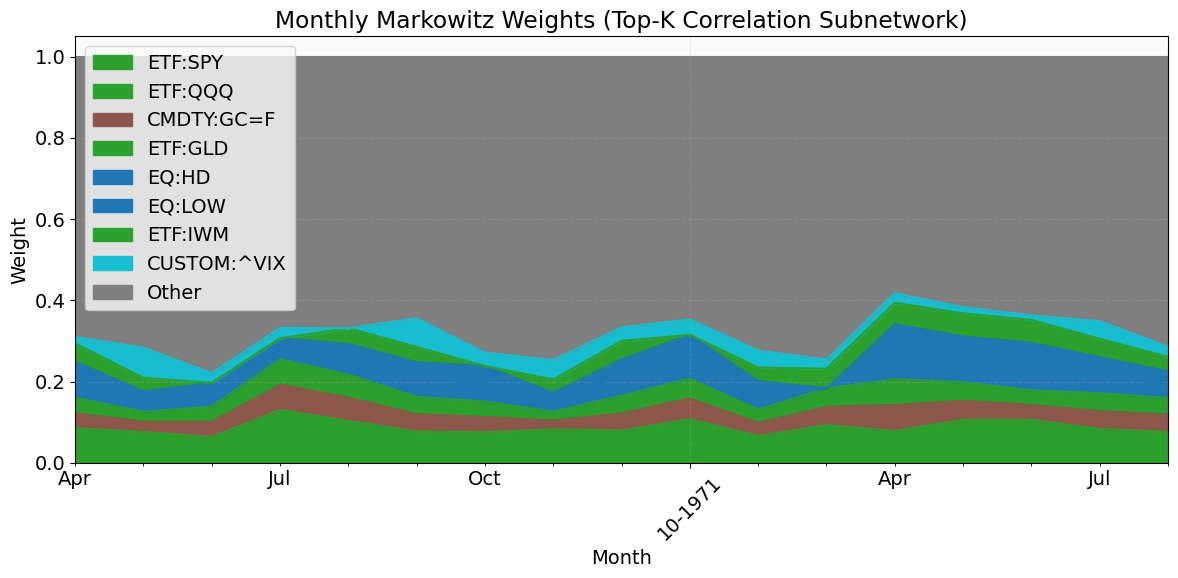

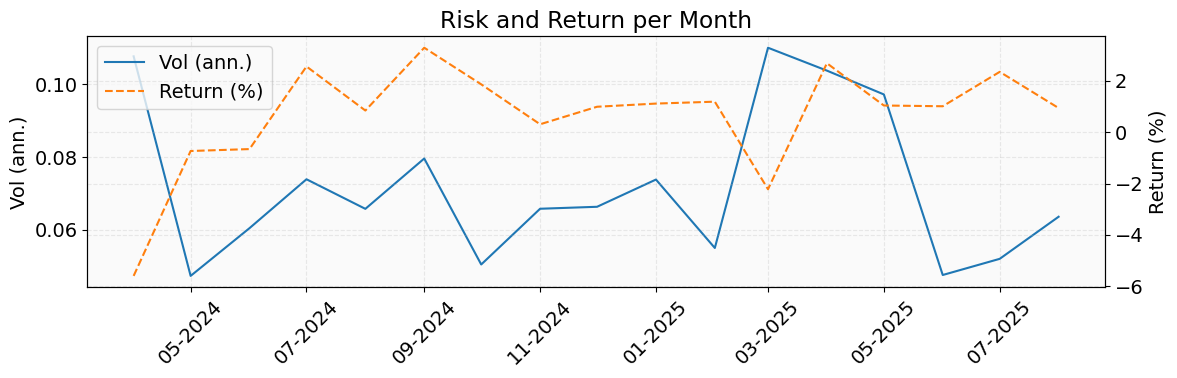

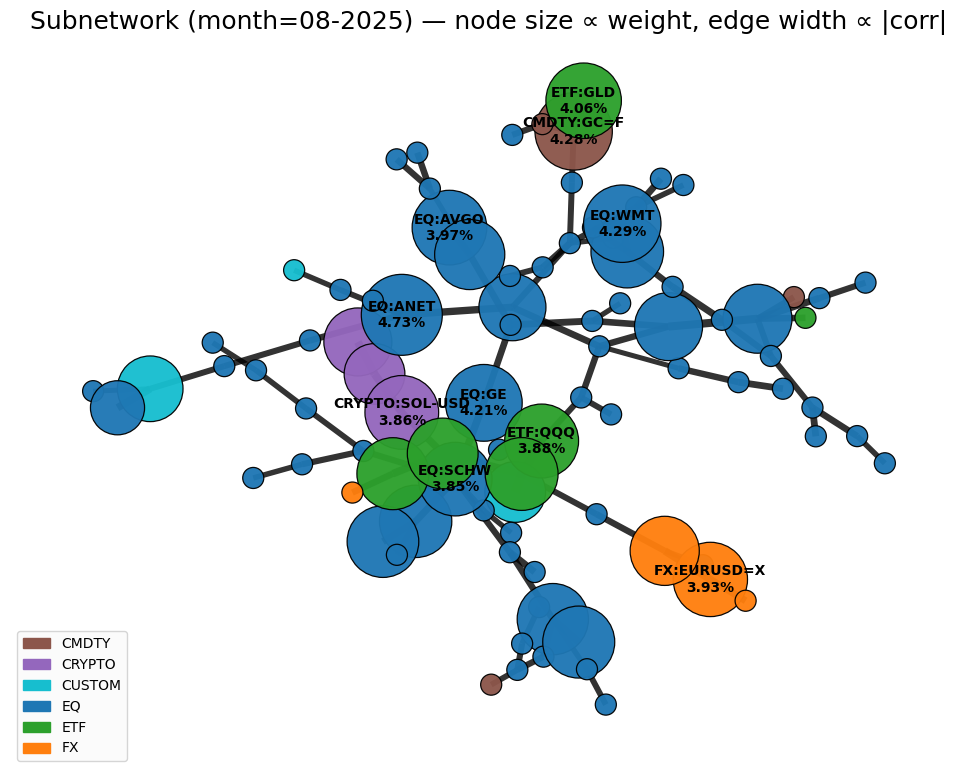

[Graph] Saved → /content/subnetwork_graph_2025-08.png
Saved graph dynamics MP4 → /content/graph_dynamics.mp4
Saved GIF → /content/graph_dynamics.gif

Done. Key outputs in /content:
 - subnetwork_markowitz_weights.csv
 - portfolio_stats_by_month.csv (Vol, Return, Turnover, TransitionCost_bps)
 - subnetwork_graph_YYYY-MM.png (last month)
 - graph_dynamics.mp4 (graph + risk/return + turnover)



In [ ]:
# @title OFFLINE Subnetwork + Markowitz from pre-downloaded CSVs (timeseries/*)
# One-cell Colab. No web calls. Robust animation (MP4 + GIF fallback), MM-YYYY axes.
# Includes: weights evolution, risk/return, turnover+transition cost, static + animated graphs.
# ---- Fix: Increased spacing between mid/bottom panels for both MP4 and GIF ----

# ===================== User knobs =====================
INPUT_DIRS = ["/content",
    "/content/timeseries", "./timeseries",
    "/mnt/data/timeseries", "/mnt/data"
]  # searched in order

# Filenames (wide = columns are assets; long = date/ticker/value)
FN_PRICES_WIDE  = "prices_adjusted_wide.csv"
FN_PRICES_LONG  = "prices_adjusted_long.csv"
FN_RET_WIDE     = "returns_final_wide.csv"
FN_RET_LONG     = "returns_final_long.csv"
FN_RET_RAW_WIDE = "returns_raw_wide.csv"    # fallback
FN_RET_RAW_LONG = "returns_raw_long.csv"    # fallback
FN_MONTHLY_CORR = "monthly_correlations_long.csv"  # optional (long format)

# Portfolio & graph
SUBNETWORK_K = 20              # Top-K |corr| edges to pick node set for optimization
ALLOW_SHORTING = False         # long-only min-variance if False
MIN_NODES_IN_SUBNETWORK = 3
TRADING_DAYS = 252
TOP_ASSETS_IN_STACKPLOT = 8

# Graph sparsification for display (independent of optimizer node set)
GRAPH_METHOD = "mst"           # "topk" | "mst" | "threshold"
GRAPH_TOPK   = SUBNETWORK_K    # if GRAPH_METHOD="topk"
GRAPH_TAU    = 0.65            # if GRAPH_METHOD="threshold"
GRAPH_LAYOUT = "spring"        # "spring" | "kamada_kawai" | "spectral"
USE_ABSOLUTE = True            # rank/sparsify by |rho|

# Turnover → transition cost (per $ traded, one-way)
ONE_WAY_COST_BPS = 5.0

# Visuals (colorblind-friendly set)
GROUP_COLORS = {
    "EQ":     "#1f77b4",  # blue
    "ETF":    "#2ca02c",  # green
    "FX":     "#ff7f0e",  # orange
    "CRYPTO": "#9467bd",  # purple
    "CMDTY":  "#8c564b",  # brown
    "CUSTOM": "#17becf",  # cyan
    "OTHER":  "#7f7f7f",  # gray
}
LABEL_FONTSIZE = 14
TITLE_FONTSIZE = 18

# Animation (slower, MM-YYYY axes, bottom panel further down)
MAKE_GRAPH_DYNAMICS = True
FPS = 10
FRAME_INTERVAL_MS = 300
VIDEO_DPI = 200
SAVE_GIF = True        # will only render GIF if MP4 fails
BOTTOM_SPACER_RATIO = 0.6  # pushes turnover panel further down
MID_TITLE_FONTSIZE = TITLE_FONTSIZE - 2
BOT_TITLE_FONTSIZE = TITLE_FONTSIZE - 2

# ===================== Setup =====================
!pip -q install networkx ffmpeg-python > /dev/null

import os, math, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.dates as mdates
from matplotlib.patches import Patch
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter
import matplotlib as mpl
import networkx as nx

# ensure ffmpeg binary exists (Colab usually has it)
try:
    import shutil, subprocess
    if shutil.which("ffmpeg") is None:
        print("Installing ffmpeg system binary...")
        subprocess.run(["apt-get","update","-qq"], check=False)
        subprocess.run(["apt-get","install","-y","ffmpeg"], check=False)
except Exception as _e:
    print("[WARN] Could not verify/install ffmpeg:", _e)

warnings.filterwarnings("ignore")
os.makedirs("/content", exist_ok=True)
mpl.rcParams.update({
    "axes.facecolor": "#fafafa",
    "figure.facecolor": "white",
    "axes.grid": True, "grid.alpha": 0.25, "grid.linestyle": "--",
    "font.size": LABEL_FONTSIZE
})

# ===================== I/O helpers =====================
def find_input_dir():
    for d in INPUT_DIRS:
        if os.path.isdir(d):
            return d
    raise FileNotFoundError("Could not find any of the input directories: " + ", ".join(INPUT_DIRS))

def load_csv_safe(path, parse_dates=True, index_col=None):
    if not os.path.exists(path): return None
    try:
        if parse_dates and index_col is not None:
            return pd.read_csv(path, parse_dates=True, index_col=index_col)
        return pd.read_csv(path)
    except Exception as e:
        print(f"[WARN] Failed to read {path}: {e}")
        return None

def coerce_datetime_index(df, name_guess="date"):
    if df is None or df.empty: return df
    if isinstance(df.index, pd.DatetimeIndex):
        return df.sort_index()
    for cand in [name_guess, "Date", "date", "DATE", "timestamp", "time"]:
        if cand in df.columns:
            out = df.copy()
            out[cand] = pd.to_datetime(out[cand])
            out = out.set_index(cand).sort_index()
            return out
    first = df.columns[0]
    try:
        out = df.copy()
        out[first] = pd.to_datetime(out[first])
        out = out.set_index(first).sort_index()
        return out
    except Exception:
        return df

def ensure_wide(df, date_col="date", name_col="ticker"):
    """If df is long, pivot to wide (index=datetime, columns=assets)."""
    if df is None or df.empty: return None
    if isinstance(df.index, pd.DatetimeIndex) and df.shape[1] > 1 and (not isinstance(df.columns, pd.MultiIndex)):
        return df.sort_index()
    cols = [str(c).lower() for c in df.columns]
    if ("date" in cols or "time" in cols or "timestamp" in cols) and any(
        c in cols for c in ["ticker","symbol","asset","name","label"]
    ):
        lower_map = {c.lower(): c for c in df.columns}
        dcol = lower_map.get("date", lower_map.get("time", lower_map.get("timestamp", date_col)))
        ncol = lower_map.get("ticker", lower_map.get("symbol", lower_map.get("asset", lower_map.get("name", name_col))))
        vcol = [c for c in df.columns if c not in [dcol, ncol]][0]
        tmp = df[[dcol, ncol, vcol]].copy()
        tmp[dcol] = pd.to_datetime(tmp[dcol])
        wide = tmp.pivot_table(index=dcol, columns=ncol, values=vcol, aggfunc="first").sort_index()
        wide.columns = wide.columns.astype(str)
        return wide
    return coerce_datetime_index(df)

def get_label_group(label: str):
    return label.split(":",1)[0] if (isinstance(label, str) and ":" in label) else "OTHER"

def mmYYYY(ax):
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%Y"))
    plt.setp(ax.get_xticklabels(), rotation=45)

# ===================== Load pre-downloaded data =====================
in_dir = find_input_dir()
print(f"Using input directory: {in_dir}")

# Prefer returns_final_wide/long; fallback to returns_raw_*; finally derive from prices
R_wide = ensure_wide(coerce_datetime_index(load_csv_safe(os.path.join(in_dir, FN_RET_WIDE), index_col=0)))
if R_wide is None:
    R_long = load_csv_safe(os.path.join(in_dir, FN_RET_LONG))
    R_wide = ensure_wide(R_long)

if R_wide is None:
    R_wide = ensure_wide(coerce_datetime_index(load_csv_safe(os.path.join(in_dir, FN_RET_RAW_WIDE), index_col=0)))
    if R_wide is None:
        R_long2 = load_csv_safe(os.path.join(in_dir, FN_RET_RAW_LONG))
        R_wide = ensure_wide(R_long2)

# If still no returns, try prices and derive log returns
if R_wide is None:
    P_wide = ensure_wide(coerce_datetime_index(load_csv_safe(os.path.join(in_dir, FN_PRICES_WIDE), index_col=0)))
    if P_wide is None:
        P_long = load_csv_safe(os.path.join(in_dir, FN_PRICES_LONG))
        P_wide = ensure_wide(P_long)
    if P_wide is None:
        raise RuntimeError("Could not find returns or prices in timeseries/. "
                           "Expected one of: returns_* or prices_* (wide or long).")
    R_wide = np.log(P_wide).diff()

# Clean panel
R_daily = R_wide.dropna(how="all").sort_index()
R_daily = R_daily.loc[~R_daily.index.duplicated(keep="first")].dropna(axis=1, how="all")

if R_daily.shape[1] < 3:
    raise RuntimeError("Not enough instruments in returns panel after cleaning.")

# Optional: precomputed monthly correlations (long format)
monthly_corr_long = load_csv_safe(os.path.join(in_dir, FN_MONTHLY_CORR))
if monthly_corr_long is not None:
    lc = [c.lower() for c in monthly_corr_long.columns]
    if "month" not in lc:
        raise RuntimeError("monthly_correlations_long.csv must contain a 'month' column.")
    cname = {c.lower(): c for c in monthly_corr_long.columns}
    col1 = cname.get("col_1"); col2 = cname.get("col_2"); cc = cname.get("correlation")
    if not (col1 and col2 and cc):
        nonm = [c for c in monthly_corr_long.columns if c.lower() != "month"]
        if len(nonm) >= 3:
            col1, col2, cc = nonm[0], nonm[1], nonm[2]
        else:
            raise RuntimeError("monthly_correlations_long.csv missing col_1/col_2/correlation.")
    monthly_corr_long["month"] = pd.to_datetime(monthly_corr_long["month"]).dt.to_period("M").dt.to_timestamp()
    print("Loaded precomputed monthly correlations (long).")
else:
    print("No precomputed monthly correlations. Will compute from returns.")

# ===================== Build weekly & monthly panels =====================
R_week  = R_daily.resample("W-FRI").sum().dropna(how="all")
R_month = R_daily.resample("M").sum().dropna(how="all")  # for realized monthly arithmetic return
C_full  = R_week.corr()

def monthly_all_corrs_from_weekly(R_weekly):
    out={}
    for p in R_weekly.index.to_period("M").unique().sort_values():
        r=R_weekly.loc[R_weekly.index.to_period("M")==p]
        if r.shape[0] >= 3: out[p.to_timestamp()] = r.corr()
    return out

if monthly_corr_long is None:
    monthly_corrs = monthly_all_corrs_from_weekly(R_week)
else:
    monthly_corrs = {}
    cname = {c.lower(): c for c in monthly_corr_long.columns}
    col1 = cname["col_1"]; col2 = cname["col_2"]; cc = cname["correlation"]
    for m, g in monthly_corr_long.groupby("month"):
        labels = sorted(set(pd.concat([g[col1], g[col2]]).astype(str)))
        M = pd.DataFrame(np.eye(len(labels)), index=labels, columns=labels)
        for _, row in g.iterrows():
            a, b, v = str(row[col1]), str(row[col2]), float(row[cc])
            if a in M.index and b in M.columns:
                M.loc[a, b] = v; M.loc[b, a] = v
        monthly_corrs[pd.Timestamp(m)] = M

print(f"Weekly obs: {R_week.shape[0]}  |  Assets: {R_week.shape[1]}")

# ===================== Correlation helpers =====================
def _top_k_corr_edges(corr_df: pd.DataFrame, K: int, use_abs: bool = True):
    cols = corr_df.columns; pairs = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            v = float(corr_df.iloc[i, j]); s = abs(v) if use_abs else v
            pairs.append((cols[i], cols[j], v, s))
    pairs.sort(key=lambda x: x[3], reverse=True)
    return [(a, b, v) for (a, b, v, _) in pairs[:K]]

def sparsify_corr(cdf, method="mst", k=40, tau=0.6, use_abs=True):
    labels = list(cdf.columns); vals = []
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            rho = float(cdf.iloc[i, j]); score = abs(rho) if use_abs else rho
            vals.append((labels[i], labels[j], rho, score))
    if method == "topk":
        vals.sort(key=lambda x: x[3], reverse=True); chosen = vals[:k]
        return [(a,b,rho) for a,b,rho,_ in chosen]
    if method == "threshold":
        return [(a,b,rho) for (a,b,rho,_) in vals if abs(rho) >= float(tau)]
    # MST on distance d = 1 - |rho|
    Gtmp = nx.Graph()
    for a,b,rho,_ in vals:
        d = 1.0 - abs(rho); d = d if math.isfinite(d) else 1.0
        Gtmp.add_edge(a, b, weight=d, corr=rho)
    if Gtmp.number_of_nodes() == 0: return []
    T = nx.minimum_spanning_tree(Gtmp, weight="weight")
    return [(u, v, T[u][v].get("corr", 0.0)) for u, v in T.edges()]

# ===================== Markowitz (min-variance) =====================
def _min_variance_weights(cov: pd.DataFrame, allow_short: bool = False, eps_reg: float = 1e-6) -> pd.Series:
    Sigma = cov.values + eps_reg * np.eye(cov.shape[0]); ones = np.ones(Sigma.shape[0])
    if allow_short:
        try: invS = np.linalg.inv(Sigma)
        except np.linalg.LinAlgError: invS = np.linalg.pinv(Sigma)
        w = invS @ ones; w = w / (ones @ w)
        return pd.Series(w, index=cov.columns)
    # long-only via Euclidean projection onto simplex
    w = np.ones(Sigma.shape[0]) / Sigma.shape[0]; lr = 0.05
    for _ in range(1500):
        grad = 2 * (Sigma @ w); w = w - lr * grad
        u = np.sort(w)[::-1]; cssv = np.cumsum(u) - 1; ind = np.arange(1, len(u)+1)
        cond = u - cssv / ind > 0
        if not np.any(cond): theta = cssv[-1] / len(u)
        else: rho = np.nonzero(cond)[0][-1]; theta = cssv[rho] / (rho + 1.0)
        w = np.maximum(w - theta, 0.0)
    return pd.Series(w, index=cov.columns)

def annualize_vol(port_var_daily, trading_days=TRADING_DAYS):
    return float(np.sqrt(port_var_daily * trading_days))

# ===================== Build monthly portfolios (Top-K node set) =====================
weights_by_month = {}
vol_by_month = {}
ret_by_month = {}
turnover_by_month = {}
cost_bps_by_month = {}
prev_w = None

months_sorted = sorted(monthly_corrs.keys())
for m in months_sorted:
    r_week_m = R_week.loc[R_week.index.to_period("M")==pd.Timestamp(m).to_period("M")]
    if r_week_m.shape[0] < 3: continue
    C_m = monthly_corrs[m]

    edges_for_opt = _top_k_corr_edges(C_m, K=SUBNETWORK_K, use_abs=USE_ABSOLUTE)
    if not edges_for_opt: continue
    nodes = sorted({u for u,v,_ in edges_for_opt} | {v for u,v,_ in edges_for_opt})
    if len(nodes) < MIN_NODES_IN_SUBNETWORK: continue

    cov = r_week_m[nodes].cov()
    w = _min_variance_weights(cov, allow_short=ALLOW_SHORTING)

    # Realized (daily) within the same month
    r_d_month = R_daily.loc[R_daily.index.to_period("M")==pd.Timestamp(m).to_period("M")]
    port_r_daily = (r_d_month[w.index] @ w.values)
    var_daily = float(port_r_daily.var(ddof=1))
    vol_ann = annualize_vol(var_daily, trading_days=TRADING_DAYS)
    month_log_ret = float(port_r_daily.sum())
    month_arith_ret = float(np.expm1(month_log_ret))

    # Turnover & transition cost
    if prev_w is None:
        turnover, cost_bps = 0.0, 0.0
    else:
        union = sorted(set(prev_w.index) | set(w.index))
        prev_vec = prev_w.reindex(union).fillna(0.0).values
        cur_vec  = w.reindex(union).fillna(0.0).values
        turnover = float(np.sum(np.abs(cur_vec - prev_vec)) / 2.0)
        cost_bps = float(turnover * 2.0 * ONE_WAY_COST_BPS)

    weights_by_month[m] = w
    vol_by_month[m] = vol_ann
    ret_by_month[m] = month_arith_ret
    turnover_by_month[m] = turnover
    cost_bps_by_month[m] = cost_bps
    prev_w = w

if not weights_by_month:
    raise RuntimeError("No valid months produced a subnetwork. Increase SUBNETWORK_K or check data coverage.")

# ===================== Collect panels & save =====================
all_assets = sorted(set(a for w in weights_by_month.values() for a in w.index))
W = pd.DataFrame(0.0, index=pd.to_datetime(sorted(weights_by_month.keys())), columns=all_assets)
for m, w in weights_by_month.items():
    W.loc[pd.Timestamp(m), w.index] = w.values
W = W.sort_index()

V    = pd.Series(vol_by_month, name="Vol_ann").sort_index()
RET  = pd.Series(ret_by_month, name="Return").sort_index()
TURN = pd.Series(turnover_by_month, name="Turnover").sort_index()
COST = pd.Series(cost_bps_by_month, name="TransitionCost_bps").sort_index()

W.to_csv("/content/subnetwork_markowitz_weights.csv")
pd.concat([V, RET, TURN, COST], axis=1).to_csv("/content/portfolio_stats_by_month.csv")
print("Saved → /content/subnetwork_markowitz_weights.csv, /content/portfolio_stats_by_month.csv")

# ===================== Plots (MM-YYYY) =====================
# Weights evolution (stacked area)
N_top = min(TOP_ASSETS_IN_STACKPLOT, max(1, int(np.ceil(W.shape[1] * 0.25))))
avg_w = W.mean().sort_values(ascending=False)
top_assets = list(avg_w.head(N_top).index)
W_top = W[top_assets]
other = (W.drop(columns=top_assets, errors="ignore")).sum(axis=1)
W_plot = W_top.copy(); W_plot["Other"] = other

ax = W_plot.plot.area(figsize=(12, 6),
                      color=[GROUP_COLORS.get(get_label_group(c),"#7f7f7f") for c in W_plot.columns])
ax.set_title("Monthly Markowitz Weights (Top-K Correlation Subnetwork)")
ax.set_xlabel("Month"); ax.set_ylabel("Weight"); mmYYYY(ax)
plt.tight_layout(); plt.show()

# Risk & Return overview
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(V.index, V.values, label="Vol (ann.)", color="#1f77b4")
ax2 = ax.twinx()
ax2.plot(RET.index, 100*np.array(RET.values), linestyle="--", label="Return (%)", color="#ff7f0e")
ax.set_title("Risk and Return per Month")
ax.set_ylabel("Vol (ann.)"); ax2.set_ylabel("Return (%)")
mmYYYY(ax); mmYYYY(ax2)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines+lines2, labels+labels2, loc="upper left")
plt.tight_layout(); plt.show()

# ===================== Static subnetwork graph (last month) =====================
def layout_positions(G, layout="spring", seed=42):
    if layout == "kamada_kawai": return nx.kamada_kawai_layout(G, weight="w", scale=1.0)
    if layout == "spectral": return nx.spectral_layout(G)
    return nx.spring_layout(G, seed=seed, weight="w")

def plot_subnetwork_graph_for_month(month_ts, weights_df=W, monthly_corrs_dict=monthly_corrs,
                                    method=GRAPH_METHOD, k=GRAPH_TOPK, tau=GRAPH_TAU,
                                    layout=GRAPH_LAYOUT, save_path=None, show=True):
    m = pd.Timestamp(month_ts).to_period("M").to_timestamp()
    C_m = monthly_corrs_dict.get(m)
    if C_m is None:
        print(f"[Graph] No corr matrix for {m}."); return None
    edges = sparsify_corr(C_m, method=method, k=k, tau=tau, use_abs=USE_ABSOLUTE)
    if not edges:
        edges = _top_k_corr_edges(C_m, K=SUBNETWORK_K, use_abs=USE_ABSOLUTE)
        if not edges:
            print(f"[Graph] No edges for {m}."); return None
    nodes = sorted({u for u,v,_ in edges} | {v for u,v,_ in edges})
    try:
        w_row = weights_df.loc[m]
    except KeyError:
        pos = weights_df.index.get_indexer([m], method="nearest")
        w_row = weights_df.iloc[pos[0]] if (len(pos) and pos[0] != -1) else pd.Series(dtype=float)
    w_sub = w_row.reindex(nodes).fillna(0.0)

    G = nx.Graph()
    for n in nodes: G.add_node(n, w=float(w_sub.get(n, 0.0)))
    for a,b,rho in edges: G.add_edge(a,b, corr=float(rho), w=float(abs(rho)))

    if w_sub.max() > 0:
        w_scaled = (w_sub - w_sub.min()) / (w_sub.max() - w_sub.min() + 1e-12)
    else:
        w_scaled = 0.0 * w_sub
    NODE_MIN, NODE_MAX = 230, 3400
    node_sizes = NODE_MIN + (NODE_MAX - NODE_MIN) * w_scaled.values
    edge_ws = [0.8 + (6.5 - 0.8) * (G[u][v]["w"]) for u, v in G.edges()]
    pos = layout_positions(G, layout=GRAPH_LAYOUT)
    node_colors = [GROUP_COLORS.get(get_label_group(n), GROUP_COLORS["OTHER"]) for n in G.nodes()]
    present_groups = sorted({get_label_group(n) if ":" in n else "OTHER" for n in G.nodes()})
    legend_handles = [Patch(color=GROUP_COLORS.get(g, GROUP_COLORS["OTHER"]), label=g) for g in present_groups]

    plt.figure(figsize=(10,8))
    nx.draw_networkx_edges(G, pos, alpha=0.8, width=edge_ws)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors,
                           alpha=0.96, linewidths=0.9, edgecolors="k")
    tlabels = w_sub.sort_values(ascending=False).head(10)
    nx.draw_networkx_labels(G, {n:pos[n] for n in tlabels.index if n in pos},
                            labels={n:f"{n}\n{tlabels[n]:.2%}" for n in tlabels.index},
                            font_size=10, font_weight="bold")
    plt.title(f"Subnetwork (month={m.strftime('%m-%Y')}) — node size ∝ weight, edge width ∝ |corr|",
              fontsize=TITLE_FONTSIZE)
    plt.axis("off"); plt.legend(handles=legend_handles, loc="lower left", fontsize=10, frameon=True)
    if save_path is None: save_path=f"/content/subnetwork_graph_{m.strftime('%Y-%m')}.png"
    plt.tight_layout(); plt.savefig(save_path, dpi=220)
    if show: plt.show()
    else: plt.close()
    print(f"[Graph] Saved → {save_path}")
    return save_path

last_m = W.index.max()
plot_subnetwork_graph_for_month(last_m, monthly_corrs_dict=monthly_corrs)

# ===================== Robust graph-dynamics animation (with extra spacing) =====================
def _mmYYYY(ax):
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%Y"))
    ax.tick_params(axis="x", rotation=45)

def _safe_month_key(ts):
    return pd.Timestamp(ts).to_period("M").to_timestamp()

def _layout_positions(G, layout="spring", seed=42):
    if layout == "kamada_kawai": return nx.kamada_kawai_layout(G, weight="w", scale=1.0)
    if layout == "spectral": return nx.spectral_layout(G)
    return nx.spring_layout(G, seed=seed, weight="w")

def _sparsify_corr(cdf, method="mst", k=40, tau=0.6, use_abs=True):
    labels = list(cdf.columns); vals = []
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            rho = float(cdf.iloc[i, j]); score = abs(rho) if use_abs else rho
            vals.append((labels[i], labels[j], rho, score))
    if method == "topk":
        vals.sort(key=lambda x: x[3], reverse=True); chosen = vals[:k]
        return [(a,b,rho) for a,b,rho,_ in chosen]
    if method == "threshold":
        return [(a,b,rho) for (a,b,rho,_) in vals if abs(rho) >= float(tau)]
    Gtmp = nx.Graph()
    for a,b,rho,_ in vals:
        d = 1.0 - abs(rho)
        d = d if math.isfinite(d) else 1.0
        Gtmp.add_edge(a, b, weight=d, corr=rho)
    if Gtmp.number_of_nodes() == 0: return []
    T = nx.minimum_spanning_tree(Gtmp, weight="weight")
    return [(u, v, T[u][v].get("corr", 0.0)) for u, v in T.edges()]

def _top_k_corr_edges(corr_df: pd.DataFrame, K: int, use_abs: bool = True):
    cols = list(corr_df.columns); pairs = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            v = float(corr_df.iloc[i, j])
            s = abs(v) if use_abs else v
            pairs.append((cols[i], cols[j], v, s))
    pairs.sort(key=lambda x: x[3], reverse=True)
    return [(a, b, v) for (a, b, v, _) in pairs[:K]]

def make_graph_dynamics_animation_with_turnover_safe(
    W, V, RET, TURN, monthly_corrs,
    out_mp4="/content/graph_dynamics.mp4",
    out_gif="/content/graph_dynamics.gif",
    fps=FPS, interval_ms=FRAME_INTERVAL_MS, dpi=VIDEO_DPI,
    graph_method=GRAPH_METHOD, graph_k=GRAPH_TOPK, graph_tau=GRAPH_TAU, use_abs=True,
    group_colors=GROUP_COLORS, layout=GRAPH_LAYOUT,
    bottom_spacer_ratio=BOTTOM_SPACER_RATIO
):
    def get_label_group(label: str):
        return label.split(":",1)[0] if (isinstance(label, str) and ":" in label) else "OTHER"
    def node_color_for(n):
        return group_colors.get(get_label_group(n), group_colors["OTHER"])

    months = pd.Index([_safe_month_key(x) for x in W.index]).unique().sort_values()
    if len(months) < 2:
        print("Not enough months for dynamics."); return

    # Fixed x-range & y-lims
    x0, x1 = months[0], months[-1]
    vol_vals  = V.reindex(months).values.astype(float)
    ret_vals  = (RET.reindex(months).values.astype(float)) * 100.0
    turn_vals = (TURN.reindex(months).values.astype(float)) * 100.0
    def _lims(a, pad=0.1, floor0=False):
        a = a[np.isfinite(a)]
        if a.size == 0: return (0, 1)
        lo, hi = float(np.nanmin(a)), float(np.nanmax(a))
        padv = pad * (hi - lo + 1e-12)
        lo2, hi2 = lo - padv, hi + padv
        if floor0: lo2 = 0.0
        return (lo2, hi2)
    vol_ylim  = _lims(vol_vals, pad=0.05)
    ret_ylim  = _lims(ret_vals, pad=0.10)
    turn_ylim = _lims(turn_vals, pad=0.10, floor0=True)

    # ---------- Base figure (used for MP4; GIF rebuilds per frame) ----------
    def build_figure():
        fig = plt.figure(figsize=(12, 13))
        gs = fig.add_gridspec(4, 1, height_ratios=[3, bottom_spacer_ratio, 1, 1], hspace=1.0)
        ax_top = fig.add_subplot(gs[0, 0]); ax_top.set_axis_off()
        ax_mid = fig.add_subplot(gs[2, 0]); ax2_mid = ax_mid.twinx()
        ax_bot = fig.add_subplot(gs[3, 0])

        # global extra margins & spacing to avoid title/label clash
        fig.subplots_adjust(top=0.92, bottom=0.08, hspace=1.25)

        # mid axes setup
        ax_mid.set_title("Portfolio Risk & Return", fontsize=MID_TITLE_FONTSIZE)
        ax_mid.set_xlim(x0, x1); ax2_mid.set_xlim(x0, x1)
        ax_mid.set_ylim(*vol_ylim); ax2_mid.set_ylim(*ret_ylim)
        _mmYYYY(ax_mid); _mmYYYY(ax2_mid)

        # bottom axes setup
        ax_bot.set_title("Portfolio Turnover", fontsize=BOT_TITLE_FONTSIZE)
        ax_bot.set_xlim(x0, x1); ax_bot.set_ylim(*turn_ylim); ax_bot.set_ylabel("Turnover %")
        _mmYYYY(ax_bot)

        return fig, ax_top, ax_mid, ax2_mid, ax_bot

    # ---------- MP4 (fast: update artists) ----------
    fig, ax_top, ax_mid, ax2_mid, ax_bot = build_figure()
    ln_vol, = ax_mid.plot([], [], label="Vol (ann.)", color="#1f77b4")
    ln_ret, = ax2_mid.plot([], [], label="Return (%)", color="#ff7f0e", linestyle="--")
    pt_vol = ax_mid.plot([], [], marker="o", color="#1f77b4")[0]
    pt_ret = ax2_mid.plot([], [], marker="o", color="#ff7f0e")[0]
    ln_turn, = ax_bot.plot([], [], label="Turnover (%)", color="#2ca02c")
    pt_turn = ax_bot.plot([], [], marker="o", color="#2ca02c")[0]
    ax_mid.legend(loc="upper left"); ax_bot.legend(loc="upper left")

    def draw_frame_fast(idx):
        try:
            # --- Top graph ---
            ax_top.clear(); ax_top.set_axis_off()
            m = months[idx]
            C_m = monthly_corrs.get(m)
            if C_m is None or C_m.shape[1] < 2:
                ax_top.set_title(f"(no graph) — {m.strftime('%m-%Y')}", fontsize=TITLE_FONTSIZE-1)
            else:
                edges = _sparsify_corr(C_m, method=graph_method, k=graph_k, tau=graph_tau, use_abs=use_abs)
                if not edges:
                    edges = _top_k_corr_edges(C_m, K=graph_k, use_abs=use_abs)
                nodes = sorted({u for u,v,_ in edges} | {v for u,v,_ in edges}) if edges else list(C_m.columns)
                try:
                    w_row = W.loc[m]
                except KeyError:
                    pos = W.index.get_indexer([m], method="nearest")
                    w_row = W.iloc[pos[0]] if (len(pos) and pos[0] != -1) else pd.Series(dtype=float)
                w_sub = w_row.reindex(nodes).fillna(0.0)

                G = nx.Graph()
                for n in nodes: G.add_node(n, w=float(w_sub.get(n, 0.0)))
                for a,b,rho in edges: G.add_edge(a,b, corr=float(rho), w=float(abs(rho)))

                if w_sub.max() > 0:
                    ws = (w_sub - w_sub.min()) / (w_sub.max() - w_sub.min() + 1e-12)
                else:
                    ws = 0.0 * w_sub
                node_sizes = 230 + (3400 - 230) * ws.values
                edge_ws = [0.8 + (6.5 - 0.8) * (G[u][v]["w"]) for u, v in G.edges()]
                pos = _layout_positions(G, layout=layout)
                node_colors = [group_colors.get(get_label_group(n), group_colors["OTHER"]) for n in G.nodes()]
                nx.draw_networkx_edges(G, pos, alpha=0.8, width=edge_ws, ax=ax_top)
                nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors,
                                       alpha=0.96, linewidths=0.9, edgecolors="k", ax=ax_top)
                tlabels = w_sub.sort_values(ascending=False).head(8)
                lab_pos = {n:pos[n] for n in tlabels.index if n in pos}
                if lab_pos:
                    nx.draw_networkx_labels(G, lab_pos,
                                            labels={n:f"{n}\n{tlabels[n]:.2%}" for n in lab_pos.keys()},
                                            font_size=9, font_weight="bold", ax=ax_top)
                ax_top.set_title(f"Graph Dynamics — {m.strftime('%m-%Y')}", fontsize=TITLE_FONTSIZE)

            # --- Mid & Bottom: update artists (fast) ---
            xs = months[:idx+1]; xvals = list(xs)
            vol = V.reindex(xs).values
            ret = (RET.reindex(xs).values) * 100
            tur = (TURN.reindex(xs).values) * 100
            ln_vol.set_data(xvals, vol);    pt_vol.set_data([xvals[-1]], [vol[-1] if len(vol) else np.nan])
            ln_ret.set_data(xvals, ret);    pt_ret.set_data([xvals[-1]], [ret[-1] if len(ret) else np.nan])
            ln_turn.set_data(xvals, tur);   pt_turn.set_data([xvals[-1]], [tur[-1] if len(tur) else np.nan])
        except Exception as e:
            ax_top.clear(); ax_top.set_axis_off()
            ax_top.text(0.5, 0.5, f"Skipped frame {months[idx].strftime('%m-%Y')}\n{e}",
                        ha="center", va="center", fontsize=12, transform=ax_top.transAxes)

    anim = FuncAnimation(fig, draw_frame_fast, frames=len(months), interval=FRAME_INTERVAL_MS, repeat=False)
    mp4_ok = False
    try:
        writer = FFMpegWriter(fps=FPS, bitrate=5000)
        anim.save(out_mp4, writer=writer, dpi=VIDEO_DPI, savefig_kwargs={"facecolor": "white"})
        print(f"Saved graph dynamics MP4 → {out_mp4}")
        mp4_ok = True
    except Exception as e:
        print("MP4 render failed (will try GIF):", e)
    plt.close(fig)

    # ---------- GIF fallback (safe: full re-plot each frame + same spacing) ----------
    if SAVE_GIF and out_gif:
        fig2, ax_top, ax_mid, ax2_mid, ax_bot = build_figure()
        ax_mid.legend(loc="upper left"); ax_bot.legend(loc="upper left")

        def draw_frame_replot(idx):
            try:
                for a in (ax_mid, ax2_mid, ax_bot):
                    a.cla()
                # rebuild mid/bot axes (labels/limits/formatters)
                fig2.subplots_adjust(top=0.92, bottom=0.08, hspace=1.25)
                ax_mid.set_title("Portfolio Risk & Return", fontsize=MID_TITLE_FONTSIZE)
                ax_mid.set_xlim(x0, x1); ax2_mid.set_xlim(x0, x1)
                ax_mid.set_ylim(*vol_ylim); ax2_mid.set_ylim(*ret_ylim)
                _mmYYYY(ax_mid); _mmYYYY(ax2_mid)
                ax_bot.set_title("Portfolio Turnover", fontsize=BOT_TITLE_FONTSIZE)
                ax_bot.set_xlim(x0, x1); ax_bot.set_ylim(*turn_ylim); ax_bot.set_ylabel("Turnover %")
                _mmYYYY(ax_bot)

                # TOP graph
                ax_top.clear(); ax_top.set_axis_off()
                m = months[idx]
                C_m = monthly_corrs.get(m)
                if C_m is None or C_m.shape[1] < 2:
                    ax_top.set_title(f"(no graph) — {m.strftime('%m-%Y')}", fontsize=TITLE_FONTSIZE-1)
                else:
                    edges = _sparsify_corr(C_m, method=graph_method, k=graph_k, tau=graph_tau, use_abs=use_abs)
                    if not edges:
                        edges = _top_k_corr_edges(C_m, K=graph_k, use_abs=use_abs)
                    nodes = sorted({u for u,v,_ in edges} | {v for u,v,_ in edges}) if edges else list(C_m.columns)
                    try:
                        w_row = W.loc[m]
                    except KeyError:
                        pos = W.index.get_indexer([m], method="nearest")
                        w_row = W.iloc[pos[0]] if (len(pos) and pos[0] != -1) else pd.Series(dtype=float)
                    w_sub = w_row.reindex(nodes).fillna(0.0)
                    G = nx.Graph()
                    for n in nodes: G.add_node(n, w=float(w_sub.get(n, 0.0)))
                    for a,b,rho in edges: G.add_edge(a,b, corr=float(rho), w=float(abs(rho)))
                    if w_sub.max() > 0:
                        ws = (w_sub - w_sub.min()) / (w_sub.max() - w_sub.min() + 1e-12)
                    else:
                        ws = 0.0 * w_sub
                    node_sizes = 230 + (3400 - 230) * ws.values
                    edge_ws = [0.8 + (6.5 - 0.8) * (G[u][v]["w"]) for u, v in G.edges()]
                    pos = _layout_positions(G, layout=layout)
                    node_colors = [group_colors.get(get_label_group(n), group_colors["OTHER"]) for n in G.nodes()]
                    nx.draw_networkx_edges(G, pos, alpha=0.8, width=edge_ws, ax=ax_top)
                    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors,
                                           alpha=0.96, linewidths=0.9, edgecolors="k", ax=ax_top)
                    tlabels = w_sub.sort_values(ascending=False).head(8)
                    lab_pos = {n:pos[n] for n in tlabels.index if n in pos}
                    if lab_pos:
                        nx.draw_networkx_labels(G, lab_pos,
                                                labels={n:f"{n}\n{tlabels[n]:.2%}" for n in lab_pos.keys()},
                                                font_size=9, font_weight="bold", ax=ax_top)
                    ax_top.set_title(f"Graph Dynamics — {m.strftime('%m-%Y')}", fontsize=TITLE_FONTSIZE)

                # HIST lines up to idx (full re-plot so Pillow captures cleanly)
                xs = months[:idx+1]; xvals = list(xs)
                vol = V.reindex(xs).values
                ret = (RET.reindex(xs).values) * 100
                tur = (TURN.reindex(xs).values) * 100
                ax_mid.plot(xvals, vol, label="Vol (ann.)", color="#1f77b4")
                ax2_mid.plot(xvals, ret, label="Return (%)", color="#ff7f0e", linestyle="--")
                if len(xvals):
                    ax_mid.plot([xvals[-1]],[vol[-1]], marker="o", color="#1f77b4")
                    ax2_mid.plot([xvals[-1]],[ret[-1]], marker="o", color="#ff7f0e")
                ax_bot.plot(xvals, tur, label="Turnover (%)", color="#2ca02c")
                if len(xvals):
                    ax_bot.plot([xvals[-1]],[tur[-1]], marker="o", color="#2ca02c")
                ax_mid.legend(loc="upper left"); ax_bot.legend(loc="upper left")
            except Exception as e:
                ax_top.clear(); ax_top.set_axis_off()
                ax_top.text(0.5, 0.5, f"Skipped frame {months[idx].strftime('%m-%Y')}\n{e}",
                            ha="center", va="center", fontsize=12, transform=ax_top.transAxes)

        anim2 = FuncAnimation(fig2, draw_frame_replot, frames=len(months), interval=FRAME_INTERVAL_MS, repeat=False)
        try:
            writer = PillowWriter(fps=max(6, FPS//2))
            anim2.save(out_gif, writer=writer, dpi=160, savefig_kwargs={"facecolor": "white"})
            print(f"Saved GIF → {out_gif}")
        except Exception as e:
            print("GIF render failed:", e)
        plt.close(fig2)

if MAKE_GRAPH_DYNAMICS:
    make_graph_dynamics_animation_with_turnover_safe(
        W=W, V=V, RET=RET, TURN=TURN, monthly_corrs=monthly_corrs,
        out_mp4="/content/graph_dynamics.mp4",
        out_gif="/content/graph_dynamics.gif",
        fps=FPS, interval_ms=FRAME_INTERVAL_MS, dpi=VIDEO_DPI,
        graph_method=GRAPH_METHOD, graph_k=GRAPH_TOPK, graph_tau=GRAPH_TAU,
        use_abs=True, group_colors=GROUP_COLORS, layout=GRAPH_LAYOUT,
        bottom_spacer_ratio=BOTTOM_SPACER_RATIO
    )

print("\nDone. Key outputs in /content:\n"
      " - subnetwork_markowitz_weights.csv\n"
      " - portfolio_stats_by_month.csv (Vol, Return, Turnover, TransitionCost_bps)\n"
      " - subnetwork_graph_YYYY-MM.png (last month)\n"
      " - graph_dynamics.mp4 (graph + risk/return + turnover)\n")
